# Lab: CNN Tuning and Visualization

## Install and Update Packages

In [1]:
!pip install wandb --upgrade
!pip install grad-cam
!pip install matplotlib --upgrade

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/Lab Data/'

Mounted at /content/gdrive


## Import Modules

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from multiprocessing import cpu_count
from sklearn.metrics import classification_report, cohen_kappa_score
from collections import Counter, OrderedDict, defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import os
import copy
import csv
import wandb
from pytorch_grad_cam import GradCAM

## Basic Configurations

In [4]:
wandb_args = dict(
    api_key = '73960dd11f686734e7eb4682a0f3ea9873fabbc3', # Your API Key (access from settings)
    entity = 'u1992437',  # Your W&B username
    project = 'lab_12'
)

#################################################
# Tune the hyperparameters here
# You need not tweak/set all the hyperparameters
# Feel free to leave some out if you wish
config = dict(
    lr = 1e-4, wt = 1e-6,
    step = 5, gamma = 0.1,
    epochs = 10,
)
#################################################

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threads = cpu_count()

wandb: Currently logged in as: u1992437. Use `wandb login --relogin` to force relogin


## Preprocess Data

### Fetch the Dataset

In [5]:
!unzip -q "$root_dir""lidar_dataset.zip"
data_dir = '/content/dataset/'

mode = 'train'

###Compute Mean and Standard Deviation for Normalization

In [6]:
def computeDatasetStats(loader):
    mean, std  = 0, 0
    samples = 0.
    for images, _ in loader:
        mean += torch.mean(images, dim=(0,2,3))
        std += torch.std(images, dim=(0,2,3))
        samples += 1
    mean /= samples
    std /= samples
    return mean, std

data_transforms = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), data_transforms)
train_dataloader = DataLoader(train_data, batch_size=1024, num_workers=1)

mean, std = computeDatasetStats(train_dataloader)

###Define and Apply Transformations

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
            for x in ['train','test']}

data_sizes = {x: len(data[x]) for x in ['train','test']}

class_names = data['train'].classes
num_classes = len(class_names)

###Split Data into Training and Validation Sets

In [8]:
train_data_len = int(0.8*data_sizes['train'])
val_data_len = data_sizes['train']-train_data_len
data['train'], data['val'] = random_split(data['train'], (train_data_len,val_data_len))
data_sizes['train'] = train_data_len
data_sizes['val'] = val_data_len

### Sample and Load the Datasets

In [9]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    Adapted From:
        https://github.com/ufoym/imbalanced-dataset-sampler
    """

    def __init__(self, dataset, indices=None, num_samples=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is datasets.ImageFolder:
            return dataset.imgs[idx][1]
        elif dataset_type is Subset:
            return dataset[idx][1]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                    self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


samples = {x: max(Counter((lbl for _,lbl in data[x])).values())*num_classes
                for x in ['train','val']}
samples['test'] = max(Counter((data['test'].targets)).values())*num_classes
samplers = {x: ImbalancedDatasetSampler(data[x], num_samples=samples[x])
                for x in ['train','val','test']}
dataloaders = {x: DataLoader(data[x], batch_size=128, num_workers=1, sampler=samplers[x])
                for x in ['train','val','test']}

# Define the Network Architecture
### **Note:** Re-run this code cell each time you want to train the network from scratch!!

In [ ]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=1, padding=2)),
            ('bn0', nn.BatchNorm2d(6)),
            ('relu0', nn.ReLU()),
            ('pool0', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv1', nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5, 5), stride=1, padding=2)),
            ('bn1',  nn.BatchNorm2d(12)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('fc0', nn.Linear(in_features=12 * 25 * 25, out_features=100)),
            ('bn1', nn.BatchNorm1d(100)),
            ('relu2', nn.ReLU()),
            ('fc1', nn.Linear(in_features=100, out_features=3)),
            ('softmax', nn.Softmax(dim=1)),
            ('fc2', nn.Linear(3,3))
        ]))

    def forward(self, x):
        out = self.features(x)          # extract features
        out = out.view(out.size(0), -1) # flatten
        out = self.classifier(out)      # classify
        return out


net = LiNet()


In [10]:
class DepthwiseConv2D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 groups=1,
                 bias=True) -> None:
        super().__init__()
        self.depthwise_conv = nn.Conv2d(in_channels=in_channels,
                                        out_channels=out_channels,
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=padding,
                                        groups=groups,
                                        bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.depthwise_conv(x)

        return x




# Point-wise Convolution

class PointwiseConv2D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=True) -> None:
        super().__init__()

        self.pointwise_conv = nn.Conv2d(in_channels=in_channels,
                                        out_channels=out_channels,
                                        kernel_size=(1, 1),
                                        stride=1,
                                        padding=0,
                                        groups=1,
                                        bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.pointwise_conv(x)

        return x



# Depth-wise Separable Convolution (Merging Depth and Point wise Convolutions)

class SeparableConv2D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True) -> None:
        super().__init__()

        self.depthwise_conv = DepthwiseConv2D(in_channels=in_channels,
                                              out_channels=in_channels,
                                              kernel_size=kernel_size,
                                              stride=stride,
                                              padding=padding,
                                              groups=in_channels,
                                              bias=bias)

        self.pointwise_conv = PointwiseConv2D(in_channels=in_channels,
                                              out_channels=out_channels,
                                              bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)

        return x

In [11]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
                            ('Sep_conv1', SeparableConv2D(in_channels = 1, out_channels = 6, kernel_size=(9, 9), bias = True)),
                            ('relu1', nn.ReLU()),
                            ('batch1', nn.BatchNorm2d(6)),
                            ('pool1', nn.MaxPool2d(kernel_size=(2, 2))),

                            ('Sep_conv2', SeparableConv2D(in_channels = 6, out_channels = 12, kernel_size=(9, 9), bias = True)),
                            ('relu2', nn.ReLU()),
                            ('batch2', nn.BatchNorm2d(12)),
                            ('pool2', nn.MaxPool2d(kernel_size=(2, 2))),
                        ]))
        self.classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(4332,100)),
                            ('relu3', nn.ReLU()),
                            ('batch3', nn.BatchNorm1d(100)),

                            ('fc2', nn.Linear(100,3)),
                            ('softmax', nn.Softmax()),
                            ('batch4', nn.BatchNorm1d(3)),
                            ('fc3', nn.Linear(3,3)),
                        ]))
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

net = LiNet()


## Check if everything works correctly

In [12]:
# Create a dummy tensor of size (B x C x H x W) and pass it through the network
dummy_input = torch.randn(11, 1, 100, 100)
print(dummy_input.shape)
# Pass the dummy tensor through the network
output = net(dummy_input)

# Print the shape of the output
print(output.shape)

# Print the shape of the output and verify if it is as expected



torch.Size([11, 1, 100, 100])
torch.Size([11, 3])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


##And (optionally) load a pretrained model

In [ ]:
state_dict = torch.load(root_dir+'LiNet-adam_lr1e4_decay1e6.pth')
net.load_state_dict(state_dict)
net.eval()

# Determine the number of Parameters

In [13]:
param_count = sum(p.numel() for p in net.parameters()) / 1000000
print('\nTotal Parameter Count: %.2f M' % param_count)


Total Parameter Count: 0.43 M


### Can you determine the number of parametres in the feature extractor?

#Train and Validate

### **Note**: Re-run the code cell that defines the network architecture before starting a new run!!

Saving checkpoints in: /content/gdrive/My Drive/Lab Data/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/Lab Data/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/10
----------
Train Loss: 0.5766 Acc: 0.8964


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Val Loss: 0.5240 Acc: 0.8818

Epoch 2/10
----------
Train Loss: 0.3663 Acc: 0.9761
Val Loss: 0.4225 Acc: 0.8864

Epoch 3/10
----------
Train Loss: 0.2401 Acc: 0.9902
Val Loss: 0.3632 Acc: 0.8903

Epoch 4/10
----------
Train Loss: 0.1563 Acc: 0.9949
Val Loss: 0.3284 Acc: 0.8872

Epoch 5/10
----------
Train Loss: 0.1027 Acc: 0.9967
Val Loss: 0.3137 Acc: 0.8869

Epoch 6/10
----------
Train Loss: 0.0767 Acc: 0.9984
Val Loss: 0.3180 Acc: 0.8813

Epoch 7/10
----------
Train Loss: 0.0703 Acc: 0.9990
Val Loss: 0.3232 Acc: 0.8824

Epoch 8/10
----------
Train Loss: 0.0658 Acc: 0.9993
Val Loss: 0.3366 Acc: 0.8772

Epoch 9/10
----------
Train Loss: 0.0617 Acc: 0.9995
Val Loss: 0.3480 Acc: 0.8703

Epoch 10/10
----------
Train Loss: 0.0575 Acc: 0.9996
Val Loss: 0.3602 Acc: 0.8697

Early stopping! Completed in 15m 34s
Best val Acc: 0.886876



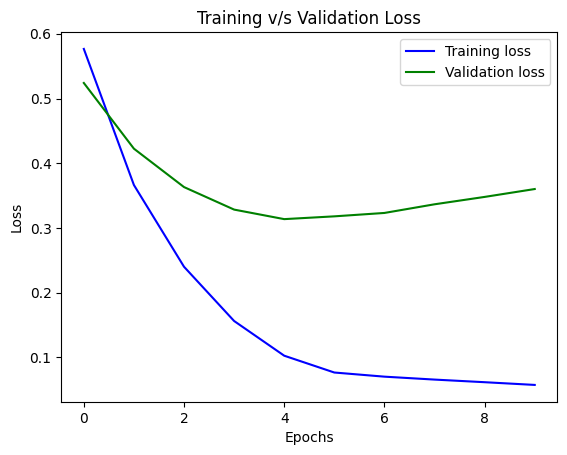

train_acc,▁▆▇███████
train_loss,█▅▃▂▂▁▁▁▁▁
val_acc,▅▇█▇▇▅▅▄▁▁
val_loss,█▅▃▁▁▁▁▂▂▃
train_acc,0.99963
train_loss,0.05754
val_acc,0.86968
val_loss,0.36016


In [14]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=config['epochs'],
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

# Evaluate the Model

In [15]:
def evaluate_model(model, classes, dataloader, out_file_path='accuracy.txt'):
    model.cpu()
    num_classes = len(classes)
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    y_true = torch.ByteTensor()
    y_pred = torch.ByteTensor()

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            num_labels = labels.size(0)
            total += num_labels
            correct += c.sum().item()
            for i in range(num_labels):         # current batch size
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            y_true = torch.cat((y_true,labels), 0)
            y_pred = torch.cat((y_pred,predicted), 0)

    with open(out_file_path, "w") as out_file:
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total))
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total), file=out_file)
        for i in range(num_classes):
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]))
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]),
                  file=out_file)
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)))
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)),
              file=out_file)
        print('\n',classification_report(y_true, y_pred, target_names=class_names))
        print('\n',classification_report(y_true, y_pred, target_names=class_names),
              file=out_file)


!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-xxx-accuracy.txt"
evaluate_model(net, class_names, dataloaders['test'] if mode=='train' else test_dataloader, out_file_path)

Accuracy of the network on 4851 test images: 96.8048%
	Accuracy of corridor : 98.0368%
	Accuracy of door : 95.4910%
	Accuracy of room : 96.8789%

Kappa Score: 0.9521

               precision    recall  f1-score   support

    corridor       0.96      0.98      0.97      1630
        door       0.99      0.95      0.97      1619
        room       0.96      0.97      0.96      1602

    accuracy                           0.97      4851
   macro avg       0.97      0.97      0.97      4851
weighted avg       0.97      0.97      0.97      4851



# Estimate the Inference Speed

In [16]:
def get_fps(model, dataloader, reps=10):
    model.to(device)
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]

            # GPU warmup
            if device == 'cuda':
                for _ in range(10):
                    _ = model(inputs)
                torch.cuda.synchronize()

            start = time.time()
            for i in range(reps):
                _ = model(inputs)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            elapsed_time = (end-start)
            inference_speed = elapsed_time / (reps * batch_size)
            throughput = (reps * batch_size) / elapsed_time
            break
    print('Inference speed: %.4f s' % inference_speed)
    print('Throughput: %d images' % throughput)

get_fps(net, dataloaders['test'] if mode=='train' else test_dataloader)

Inference speed: 0.0001 s
Throughput: 19535 images


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


# Make Predictions

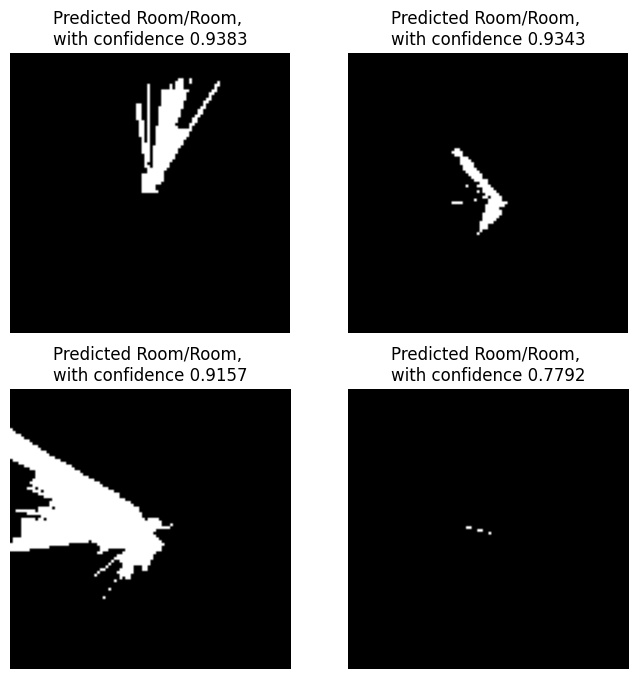

In [17]:
def predict(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(8,8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)                      # batch x channel x width x height
            labels = labels.to(device)

            outputs = model(inputs)                         # batch x classes
            prob = nn.functional.softmax(outputs, dim=-1)
            prob, idx = prob.sort(1,True)                   # batch x classes

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if num_images == 1:
                    ax = plt.subplot(1, 1, 1)
                else:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted {1}/{2}, \nwith confidence {0:.4f}'.format(prob[j][0],
                    class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
                ax.imshow(inputs.cpu().data[j].squeeze(), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


predict(net, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Filters (Features) and Activations (Feature Maps)

In [19]:
def get_convs(layers):
    conv_layers = []
    for module in layers:
        if 'Conv2d' in str(type(module)):
            conv_layers.append(module)
        elif type(module)==nn.Sequential:
            conv_layers.extend(get_convs(module.children()))
    return conv_layers

convs = get_convs(net.features)
for conv in convs:
    print(f'CONV: {conv} => SHAPE: {conv.weight.shape}')

In [22]:
def visualize_filters(convs):
    # Iterate through each convolutional layer passed in the 'convs' list
    for conv in convs:
        in_ch, out_ch = conv.in_channels, conv.out_channels

        # Set up the figure with appropriate size
        fig = plt.figure(figsize=(out_ch * 2, in_ch * 2), constrained_layout=True)
        fig.suptitle(f'CONV: {conv}', size=16)

        # Iterate through each filter and each channel of the filter
        for i in range(in_ch):
            for j in range(out_ch):
                idx = (i * out_ch) + (j + 1)
                ax = plt.subplot(in_ch, out_ch, idx)
                ax.axis('off')  # Turn off axis

                # Detach the filter from the current graph, move to cpu if needed, and convert to numpy for visualization
                filter = conv.weight.data[j][i].cpu().detach().numpy()

                # Display the filter
                ax.imshow(filter, cmap='gray')

# Retrieve the convolutional layers from the network
convs = [module for module in net.features if isinstance(module, nn.Conv2d)]

# Call the function with the convolutional layers
visualize_filters(convs)


In [ ]:
def visualize_activations(convs, dataloader):
    for inputs, labels in dataloader:
        inputs = inputs.to(device)  # B x C x H x W
        img = inputs[:1]

        activations = [convs[0](img)]
        for i in range(1, len(convs)):
            activations.append(convs[i](activations[-1]))

        for conv, act in zip(convs, activations):
            out_ch = conv.out_channels
            fig = plt.figure(figsize=(out_ch*2, 2), constrained_layout=True)
            fig.suptitle(f'CONV: {conv}', size=16)
            for j in range(out_ch):
                ax = plt.subplot(1, out_ch, j+1)
                ax.axis('off')
                ax.imshow(act.detach().squeeze()[j].cpu(), cmap='gray')
                # Dim --> B x Out Ch x H' x W'
        return


visualize_activations(convs, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Grad-CAMs

<ipython-input-24-67b55e03e415>:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


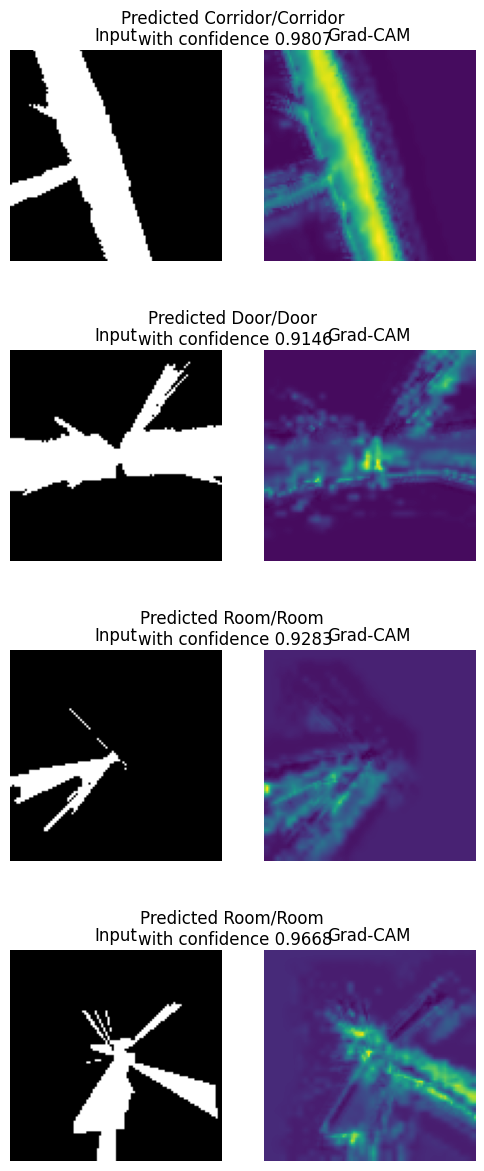

In [24]:
def visualize(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0

    cam = GradCAM(model=model, target_layers=model.features, use_cuda=False)

    fig = plt.figure(constrained_layout=True, figsize=(6,12))
    fig.tight_layout()
    subfigs = fig.subfigures(nrows=num_images, ncols=1)

    for inputs, labels in dataloader:
        inputs = inputs.to(device)                      # B x C x W x H
        labels = labels.to(device)

        outputs = model(inputs)                         # B x classes
        prob = nn.functional.softmax(outputs, dim=-1)
        prob, idx = prob.sort(1,True)                   # B x classes

        masks = cam(input_tensor=inputs[:num_images])

        for j in range(inputs.size()[0]):
            axs = subfigs[j].subplots(1, 2)
            subfigs[j].suptitle('Predicted {1}/{2} \nwith confidence {0:.4f}'.format(prob[j][0],
                class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
            axs[0].axis('off')
            axs[0].set_title('Input')
            axs[0].imshow(inputs[j].cpu().squeeze(), cmap='gray')
            axs[1].axis('off')
            axs[1].set_title('Grad-CAM')
            axs[1].imshow(masks[j])

            images_so_far += 1
            if images_so_far == num_images:
                model.train(mode=was_training)
                return

    model.train(mode=was_training)


visualize(net, dataloaders['test'] if mode=='train' else test_dataloader)

#Save the Trained Model

In [18]:
torch.save(net.state_dict(),root_dir+'<new_name_for_each_model>.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

# **Calculate by hand the difference in model parameters:**
Convolution: **bold text**
For the first Convolutional Layer,

       output size = ((W − k + (2 × P ))/S)+1
                   =(100-5+(2×2)/1)+1
                   =99

Where,
H,W→ Height and Width of the Input= (100×100)

C→ Input Channel=1

O→ Output Channel=6

k→ Kernel Size=(5×5)

P→ Padding=0

S→ Stride=1

So, Output Shape = (99×99×6)


The Total Multiplications required to compute the Convolution is:

 6×5×5×1×(99×99 locations) = 1470150 or 1.47 million.


If there is bias, the number of parameters, First Conv2D, param1 is:

param1=(k × k × C + 1) ×N
             =(5×5×1+1)×6
             =300

Second Conv2D param2 is:


param2=(k × k × C + N)+ N
                       =(5x5×6x12)+12
                       =1812

where,
H, W → Height and Width of the Input=(100×100)

C → Number of Input Channels=1

N → Number of Kernels / Feature Maps=6

k → Kernel Size=(5×5)


Total trainable parameters = 300 + 1812 = 2112




**Depth-wise Separable Convolution:**


For depth-separable convolution the total multiplications required to compute the convolution is:

for depth wise:  9×9×1×(92×92 locations) = 685584

for point wise: 6×1×1×1×(92×92 locations) = 50784.

The Total Multiplications required to compute the Depth-Separable Convolution is:
 		(685584 + 50784 )= 736368 or 0.7 million.

A considerable decrease in the number of multiplications occurs. And for that reason, the runtime is faster.

params = DW-Conv params + PW-Conv params
where,,

DW-Conv params = (k × k ×1 + 1) × C
                              

PW-Conv params = (1 × 1 × C + 1) × N

First Conv2D, param1= (k × k × C) + (C × N) + (C + N)

            =(9× 9× 1)+(1× 6)+(1+6)

            =94
Second Conv2D, param2=(k × k × C) + (C × N) + (C + N)

            =(9×9×6)+(6×12)+(6+12)
            
            =576
Total trainable parameters = 94 + 576 = 670

The depth wise separable convolution requires less time to train a model because there are significantly less trainable parameters.


**Question1: Does accounting for class imbalance really have an effect on model performance? Try it Out!**

**Answer:**The ImbalancedDatasetSampler class modifies the sampling probability for every class in order to handle the problem of imbalanced datasets. The model may become biased if Dataloaders is used without any sampler, which could result in strong performance on the majority class but subpar performance on the minority class during training. The model is more evenly exposed to all classes by implementing the ImbalancedDatasetSampler, which greatly increases its capacity to learn from minority classes and improves overall performance.

**Question2: Do you think increasing the receptive field would have a major effect on performance?**
**Try stacking convolutions or perhaps dilated convolutions to save up on learnable parameters ;)**

**Answer:**Stacking Convolutions replaces large kernels with multiple smaller kernels. The receptive field is increased while the number of parameters is kept lower and more non-linearities are introduced when numerous smaller kernels—such as multiple 3x3 kernels—are used in place of a single large kernel (in my code, I've used 5× 5 kernels).
Dilated Convolutions expands the kernel by adding zeros between the kernel elements. It allows the network to have more receptive fields while keeping the number of parameters unchanged.
So, increasing the receptive field the network may better combine local and global features with a larger range of contextual data, which results in a deeper and more thorough knowledge of the input data.

**Question3: identify the main sources of ambiguity for the model, if any. Try running a couple predictions and observing the cases where the model makes mistakes.**

**Answer:**The model performs satisfactorily on the training, validation, and test datasets despite its tendency toward overfitting. Nevertheless, it is clear from repeated prediction experiments that a sizable fraction of the genuine labels are off. This implies that the model is making memorization-based predictions since it is learning to remember the inputs instead of completely understanding them.


Depth-Separable Convolutions after removing all the convulational layers.

The original LINET model i have used standard convolutional layers with 5x5 kernels. However, the modified version replaces these with depth-separable convolutions, which use 9x9 kernels. Depth-separable convolutions, comprising depthwise and pointwise layers, are more parameter-efficient than the traditional convolutions i made. This efficiency not only reduces the model's computational load but also helps in mitigating overfitting. The larger receptive field of the 9x9 kernel in the modified Linet captures more contextual information, which can be advantageous for this datasets. Overall, the choice between standard and depth-separable convolutions hinges on the balance between model complexity and the specific needs of the task at hand.